# Task -1: Imports!

In [2]:
# Imports for data analysis and other fun things :3
import kagglehub
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, TrainingArguments, Trainer, AutoConfig, pipeline
import torch
from torch.utils.data import TensorDataset

import nltk
import string
from huggingface_hub import hf_hub_download

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get dataset from Kaggle downloaded on any machine
path = kagglehub.dataset_download("mobasshir/yelpdata")

print("Path to dataset files:", path)

Path to dataset files: /Users/charlotte/.cache/kagglehub/datasets/mobasshir/yelpdata/versions/2


In [4]:
# Import the two required data sets into variables
bus_df = pd.read_csv(f"{path}/yelp_business.csv")
review_df = pd.read_csv(f"{path}/yelp_review_arizona.csv")

In [5]:
# Display the column names of each set
print(bus_df.columns)
print(review_df.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
Index(['review_id', 'user_id', 'business_id', 'text', 'stars', 'date'], dtype='object')


# Task 0: Data Analysis

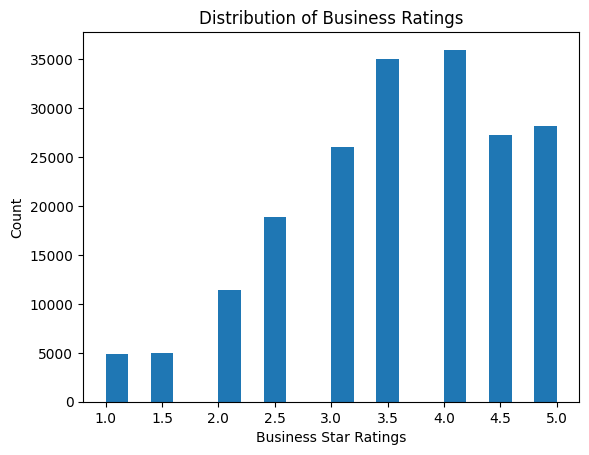

In [6]:
# Print a histograph for each star rating that a business has
bus_df['stars'].hist(bins=20)
plt.xlabel('Business Star Ratings')
plt.ylabel('Count')
plt.title('Distribution of Business Ratings')
plt.grid(False) # The grid is so ugly why is this even a default option
plt.show()

Looking at the amount of each star rating a vusiness has, the largest number of businesses have 3.5-4 stars and the fewest businesses have 1-1.5 stars. 

/var/folders/jr/slmnpm213g72bzshbxcd9wrr0000gn/T/ipykernel_83559/1202628733.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=star_ratings)


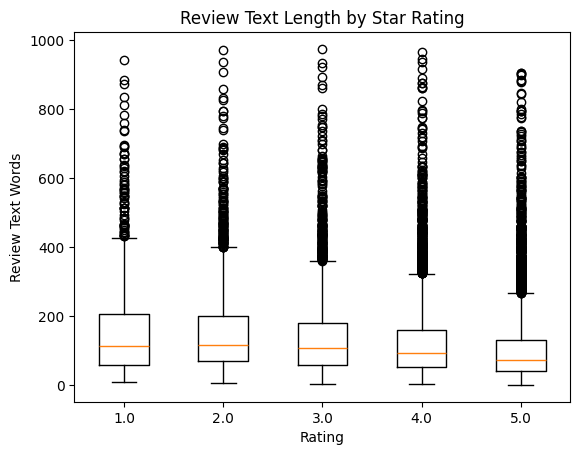

In [7]:
# Add a new column of review length in words
review_df['review_length'] = review_df['text'].apply(lambda x: len(x.split()))

# Get the list of possible star ratings
star_ratings = sorted(review_df['stars'].unique())

# Get the data where there is the proper star rating
data = [review_df[review_df['stars'] == star]['review_length'] for star in star_ratings]

# Plot the box and whisker graph
plt.figure()
plt.boxplot(data, labels=star_ratings)
plt.xlabel("Rating")
plt.ylabel("Review Text Words")
plt.title("Review Text Length by Star Rating")
plt.show()


Above is a box and whisker plot for the length of a review vs the star rating that the review gave. While there is a large range of words per star rating, you can see that there is a slight trend downwards as the more stars a rating gives, the less words used.

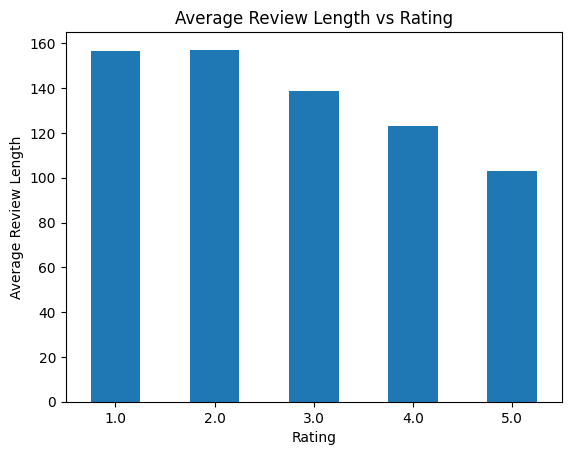

Correlation between review length and rating: -0.1683285707834346


In [8]:
# Get average review length for each star rating
avg_length = review_df.groupby('stars')['review_length'].mean()

# Display the bar graph for the review length and ratings
plt.figure()
avg_length.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Average Review Length')
plt.title('Average Review Length vs Rating')
plt.xticks(rotation=0)
plt.show()

# Print out the correlation between these variables to further see trends
correlation = review_df['review_length'].corr(review_df['stars'])
print("Correlation between review length and rating:", correlation)


This graph shows the length vs rating trend more clearly. While the correlation is low, there is still a downwards trend, with 5 star ratings having the lowest average review length. This may be explained by customers that have good experiences have less to say while customers that have bad experiences want to explain what went wrong.

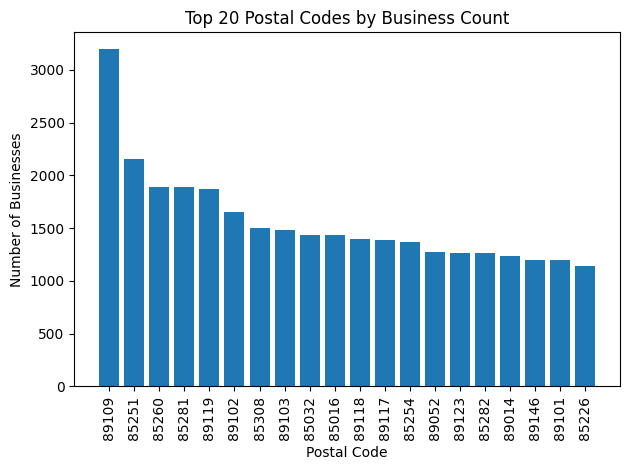

89109 is the Las Vegas postal code :)


In [9]:
# Get the count of businesses per postal code
business_counts = bus_df.groupby('postal_code')['business_id'].count().reset_index(name='business_count')

# Take only the top 20 with the most businesses
top_postal = business_counts.sort_values(by='business_count', ascending=False).head(20)

# Graph the top postal codes
plt.figure()
plt.bar(top_postal['postal_code'], top_postal['business_count'])
plt.xlabel('Postal Code')
plt.ylabel('Number of Businesses')
plt.title('Top 20 Postal Codes by Business Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print a lil fact :)
print("89109 is the Las Vegas postal code :)")

This is the bar graph for the top 20 postal codes in Arizona based off the amount of businesses within the postal code. There is one postal code, 89109, that has significantly more businesses than others. This is because this is the Las Vegas area code, a city that is extremely dense with people and businesses.

# Task 0.5: Data Cleaning

In [10]:
print("Business Data Pre-Cleaning: ", bus_df.shape)
print("Review Data Pre-Cleaning: ", review_df.shape)

Business Data Pre-Cleaning:  (192609, 14)
Review Data Pre-Cleaning:  (26606, 7)


In [11]:
# Clean the business data to the required specifications
clean_bus_df = bus_df[(bus_df['review_count'] > 50) & (bus_df['attributes'].size > 3)]

In [12]:
# Remove any duplicate businesses and reviews
clean_bus_df = clean_bus_df.drop_duplicates(subset='business_id')
clean_review_df = review_df.drop_duplicates(subset='review_id')

In [13]:
# Drop any empty columns for relevant data points
clean_bus_df = clean_bus_df.dropna(subset=['business_id', 'name', 'stars', 'review_count'])
clean_review_df = clean_review_df.dropna(subset=['review_id', 'business_id', 'stars','text'])

In [14]:
# Change data types to more reasonable types
clean_bus_df['stars'] = pd.to_numeric(clean_bus_df['stars'])
clean_bus_df['review_count'] = pd.to_numeric(clean_bus_df['review_count'])
clean_review_df['stars'] = pd.to_numeric(clean_review_df['stars'])
clean_review_df['date'] = pd.to_datetime(clean_review_df['date'])

In [15]:
# Drop extra columns to speed up learning and clear memory
clean_bus_df = clean_bus_df.drop(columns=['address', 'city', 'state', 'postal_code','latitude', 'longitude','hours'])
clean_review_df = clean_review_df.drop(columns=['user_id','date'])

In [16]:
print("Business Data Post-Cleaning: ", clean_bus_df.shape)
print("Review Data Post-Cleaning: ", clean_review_df.shape)

Business Data Post-Cleaning:  (26524, 7)
Review Data Post-Cleaning:  (26606, 5)


The biggest drop comes from the business data attribute and review classification where only businesses with enough attributes and reviews. The reviews dataset is already relatively clean and good to work with.

# Task 1: Predicting Business Attributes

In [17]:
# Merge all of the reviews for each business into one column
per_bus_reviews = review_df.groupby('business_id')['text'].apply(lambda text: " ".join(text))

# Merges the business and review data sets into one
merged_df = pd.merge(clean_bus_df, per_bus_reviews, on='business_id', how='inner')

In [18]:
unique_keys = []
target_labels = []

# Changes the attributes category from a string that looks like a dict to a dict
bus_attributes = merged_df['attributes'].apply(lambda x: eval(x))


# Creates a list of all of the unique attributes a business can have
for attributes_dict in bus_attributes:
    for key in attributes_dict.keys():
        if key not in unique_keys:
            unique_keys.append(key)

unique_attributes = sorted(unique_keys)

print("Unique attributes:", unique_attributes)

# Creates a list of all of the labels each business has seperately
for attributes_dict in bus_attributes:
    current_labels = []
    for attribute in unique_attributes:
        if attribute in attributes_dict:
            current_labels.append(attribute)
    target_labels.append(current_labels)

# Preps the multilabel binarizer and the fit labels for the BERT model
mlb = MultiLabelBinarizer(classes=unique_attributes)
labels = mlb.fit_transform(target_labels)

Unique attributes: ['AgesAllowed', 'Alcohol', 'Ambience', 'BYOB', 'BYOBCorkage', 'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards', 'BusinessParking', 'ByAppointmentOnly', 'Caters', 'CoatCheck', 'Corkage', 'DietaryRestrictions', 'DogsAllowed', 'DriveThru', 'GoodForDancing', 'GoodForKids', 'GoodForMeal', 'HappyHour', 'HasTV', 'Music', 'NoiseLevel', 'Open24Hours', 'OutdoorSeating', 'RestaurantsAttire', 'RestaurantsCounterService', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', 'RestaurantsPriceRange2', 'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 'Smoking', 'WheelchairAccessible', 'WiFi']


In [19]:
# Splits the testing and training data
train_texts, test_texts, y_train, y_test = train_test_split(merged_df['text'], labels, test_size=0.2, random_state=9)

In [20]:
# Generates the tokenizer, config, and model using DistilBert
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=len(unique_attributes), problem_type="multi_label_classification")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

# Generates the encodings for both the training and testing data
# Hyperparams set to avoid throwing errors when using the TensorDataset
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=256,return_tensors='pt')

test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding='max_length', max_length=256, return_tensors='pt')

# Gets the tensor from torch to create the dataset that the model will train on
# Torch float changes output type for model to cast as a Float later
train_labels_tensor = torch.tensor(y_train, dtype=torch.float)
test_labels_tensor = torch.tensor(y_test, dtype=torch.float)

# Creates the training and testing datasets that can be used with DistilBERT
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Creates the list of training arguments, using just the bare minimum arguments
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16
)

# Creates a function that will collect the feature outputs from the model
# Used to solve error where training the model would throw a value error
def data_collator(features):
    data = {}
    data['input_ids'] = torch.stack([f[0] for f in features])
    data['attention_mask'] = torch.stack([f[1] for f in features])
    data['labels'] = torch.stack([f[2] for f in features])
    
    return data

# Creates the list of arguments for the trainer utilizing the variables created above
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator
)

In [22]:
# Trains and evaluates the model, printing out the results
trainer.train()
eval_results = trainer.evaluate()
print("Results:", eval_results)


Step,Training Loss


Results: {'eval_loss': 0.23802001774311066, 'eval_runtime': 2.3949, 'eval_samples_per_second': 118.168, 'eval_steps_per_second': 7.516, 'epoch': 3.0}


# Task 2

In [23]:
# Download Huggingface Hub
hf_hub_download(repo_id="bigscience/T0_3B", filename="config.json", cache_dir="./huggingface")

'./huggingface/models--bigscience--T0_3B/snapshots/032a20e775dd500df0a5a7f404466183d67f172b/config.json'

In [24]:
# Configure Huggingface Json
sentiment_config = AutoConfig.from_pretrained("./huggingface/models--bigscience--T0_3B/snapshots/032a20e775dd500df0a5a7f404466183d67f172b/config.json")

In [25]:
# Establish two classification pipelines to test
text_class = pipeline("text-classification")
sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [26]:
# Test pipelines with example text
text_class("This restaurant is awesome")

[{'label': 'POSITIVE', 'score': 0.9998743534088135}]

In [27]:
print(train_texts[0])

After reading many decent reviews and seeing how close the restaurant was to home, I decided to give it a try.

The young lady at the counter was impatient and had no interpersonal skills. The food was just not good; this place is 'Chinese take-out' at best. A recent lunch at Nee House changed my whole opinion of this restaurant.  The crab and dried scallop fried rice was as good as the best fried rice I've eaten while living in Hong Kong. The rice kernels were perfectly al dente, not greasy, well-seasoned with the right restraint and the breath of the wok shined through deliciously.  Fried rice and noodles shows the real skill of a chef - it requires good control of heat and timing. 

We also had the lobster with house special sauce. The lobster was plucked live from the tanks and weighed 2.75 lbs ($15/lb) so totaled approx. $40. The sauce was addictively spicy with sliced jalapenos and ample ground black pepper with the crunch of green onion tops - a little less sugar in the sauce wo

In [28]:
# Split reviews into sentences and analyze each sentence, placing them into a dictionary

# ***(WIP)***
review_dict = dict()

review = train_texts[0] #for review in train_texts:
sentences = review.split(". ")
for sent in sentences:
    analysis = text_class(sent)
    review_dict.update(analysis)
    print(sent)
    print(analysis)

After reading many decent reviews and seeing how close the restaurant was to home, I decided to give it a try.

The young lady at the counter was impatient and had no interpersonal skills
[{'label': 'NEGATIVE', 'score': 0.9995421171188354}]
The food was just not good; this place is 'Chinese take-out' at best
[{'label': 'NEGATIVE', 'score': 0.9978306889533997}]
A recent lunch at Nee House changed my whole opinion of this restaurant
[{'label': 'NEGATIVE', 'score': 0.9771267771720886}]
 The crab and dried scallop fried rice was as good as the best fried rice I've eaten while living in Hong Kong
[{'label': 'POSITIVE', 'score': 0.9995428323745728}]
The rice kernels were perfectly al dente, not greasy, well-seasoned with the right restraint and the breath of the wok shined through deliciously
[{'label': 'POSITIVE', 'score': 0.9995661377906799}]
 Fried rice and noodles shows the real skill of a chef - it requires good control of heat and timing
[{'label': 'POSITIVE', 'score': 0.99239605665206